**In this project, we aim to predict using the features of kickstart projects whether the project is funded or not. Towards this end, we clean and preprocess the data sets and ananlyse the importance of individual features, relationship among features. We derived a few new features which deemed good in predictitability of the project. We then employ the patterns among these features for prediction using K-nearest neigbhours and Decision tree classifier. The Performance of both the methods are compared in terms of average prediction accuracy. We also breifly discuss the importance of features in prediction**


# Contents


1. Loading datasets
2. Data cleaning and Derivation of three new features
3. Exploratory data analysis
4. Prediction analysis, using
   *  knn                        (given estimator)
      - Chosing the value of parameter k using validation set
   *  decision-tree classifier   (additional estimator)
      - Chosing the number of branched using validation set
5. Performance of prediction
6. Feature selection (importance of features)

In [1]:
# Importing necessary modules and functions

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
#matplotlib inline

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier     # For KNN
from sklearn.tree import DecisionTreeClassifier       # For decision tree classifier  

from sklearn.model_selection import GridSearchCV       # For cross validation

#import warnings
#warnings.filterwarnings('ignore')
import random

In [2]:
help(random)

Help on module random:

NAME
    random - Random variable generators.

DESCRIPTION
        integers
        --------
               uniform within range
    
        sequences
        ---------
               pick random element
               pick random sample
               pick weighted random sample
               generate random permutation
    
        distributions on the real line:
        ------------------------------
               uniform
               triangular
               normal (Gaussian)
               lognormal
               negative exponential
               gamma
               beta
               pareto
               Weibull
    
        distributions on the circle (angles 0 to 2pi)
        ---------------------------------------------
               circular uniform
               von Mises
    
    General notes on the underlying Mersenne Twister core generator:
    
    * The period is 2**19937-1.
    * It is one of the most extensively tested generators

# 1. Loading Dataset 

In [2]:
# Importing the  Kick Started train and test files into a Pandas DataFrame.
# Loading the training data with the delimiter ',' and test data with delimiter ';'
 
df_train = pd.read_csv('KS_train_data.csv', delimiter = ',')
df_test=pd.read_csv('KS_test_data.csv',delimiter=';')


In [4]:
# To peek in to the column names of the data
print(df_train.columns)

print(df_test.columns)


print(df_train.shape)
print(df_test.shape)


Index(['project_id', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'pledged',
       'staff_pick', 'usd_pledged', 'location', 'funded', 'subcategory',
       'project_url', 'reward_url'],
      dtype='object')
Index(['project_id', 'blurb', 'category', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'staff_pick',
       'location', 'subcategory', 'project_url', 'reward_url'],
      dtype='object')
(100000, 21)
(78065, 16)


### We observe that in the above data, the features of the training and test are different. That is, a few features in the training data are missing in the test data. It means that, if we train a model using the features that are not in the test data, then we can not use the test data for prediction. Thus, in our analysis, we use those features that are common to both the test and training data.  For illustrating the importance of the a features, however,  explain in section 6, how the performance of the model using only the features in the training data sets.

In [279]:
df_train.head(3)


,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,launched_at,name,pledged,staff_pick,usd_pledged,location,funded,subcategory,project_url,reward_url
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.0,...,1332969260,Elsewhere Studios artist-in-residency program!,3596.0,False,3596.0,"Paonia, CO",True,mixed media,https://www.kickstarter.com/projects/hilaryeme...,https://www.kickstarter.com/projects/hilaryeme...
1,KS_000001,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.0,...,1332984145,1000 Artists: Presidential Inauguration 2013,4586.0,False,4586.0,"Washington, DC",True,public art,https://www.kickstarter.com/projects/17146650/...,https://www.kickstarter.com/projects/17146650/...
2,KS_000002,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.0,...,1332991739,MyPhoneHenge,5217.0,False,5217.0,"Frisco, TX",True,sculpture,https://www.kickstarter.com/projects/belveal/m...,https://www.kickstarter.com/projects/belveal/m...


In [5]:
df_train.dtypes

project_id                   object
backers_count                 int64
blurb                        object
category                     object
converted_pledged_amount      int64
country                      object
created_at                    int64
currency                     object
deadline                      int64
fx_rate                     float64
goal                        float64
launched_at                   int64
name                         object
pledged                     float64
staff_pick                     bool
usd_pledged                 float64
location                     object
funded                         bool
subcategory                  object
project_url                  object
reward_url                   object
dtype: object

In [280]:
 df_test.head(3)

,project_id,blurb,category,country,created_at,currency,deadline,fx_rate,goal,launched_at,name,staff_pick,location,subcategory,project_url,reward_url
0,KS_100000,We are looking to bring a Visiting Sculptor fr...,art,US,1330727362,USD,1334959598,1.0,3900.0,1332972398,Martin Luther King Jr. Sculpture on Campus!,False,"Bakersfield, CA",art,https://www.kickstarter.com/projects/153685020...,https://www.kickstarter.com/projects/153685020...
1,KS_100001,Surrealistic oil paintings capturing the metam...,art,US,1332598567,USD,1334635140,1.0,750.0,1332975679,EMERGENCE: Surreal Oil Paintings by J.J. Long,False,"Lowell, MA",painting,https://www.kickstarter.com/projects/203971390...,https://www.kickstarter.com/projects/203971390...
2,KS_100002,P.M.A.F.T.W. my upcoming solo show June 2012 a...,art,US,1332476607,USD,1333421843,1.0,1000.0,1332989843,P.M.A.F.T.W.,False,"Portland, OR",painting,https://www.kickstarter.com/projects/144231475...,https://www.kickstarter.com/projects/144231475...


In [281]:
# Looking at the target variable in the training data
df_train['funded'].head()
df_train['funded']

0        True
1        True
2        True
3        True
4        True
         ... 
99995    True
99996    True
99997    True
99998    True
99999    True
Name: funded, Length: 100000, dtype: bool

In [282]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   project_id                100000 non-null  object 
 1   backers_count             100000 non-null  int64  
 2   blurb                     99998 non-null   object 
 3   category                  100000 non-null  object 
 4   converted_pledged_amount  100000 non-null  int64  
 5   country                   99997 non-null   object 
 6   created_at                100000 non-null  int64  
 7   currency                  100000 non-null  object 
 8   deadline                  100000 non-null  int64  
 9   fx_rate                   100000 non-null  float64
 10  goal                      100000 non-null  float64
 11  launched_at               100000 non-null  int64  
 12  name                      99999 non-null   object 
 13  pledged                   100000 non-null  fl

In [7]:
# First check the missing values
df_train.isna().sum()

project_id                  0
backers_count               0
blurb                       2
category                    0
converted_pledged_amount    0
country                     3
created_at                  0
currency                    0
deadline                    0
fx_rate                     0
goal                        0
launched_at                 0
name                        1
pledged                     0
staff_pick                  0
usd_pledged                 0
location                    0
funded                      0
subcategory                 0
project_url                 0
reward_url                  0
dtype: int64

In [ ]:
# Remove the missing values


# 2. Data cleaning and Derivation of (three) new features

We performed the following steps to clean up the data for prediction 

1. **Date-time transformation**
   -As we notice in the previous cell that poject lauched dates and deadlines are in integer format. For better understanding of data and for inference, these variables have to be converted into date format.
2. **New feature variable creation** We derived three new features, namely, 
   * **ProjectLength**: Specifies the Character length of the project title
   *  **Hourlaunched** : Project launching time 
   *  **ProjectDuration**: Difference between project deadline and project launching date in weeks

In [10]:
help(pd.to_datetime)

Help on function to_datetime in module pandas.core.tools.datetimes:

to_datetime(arg, errors='raise', dayfirst=False, yearfirst=False, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)
    Convert argument to datetime.
    
    Parameters
    ----------
    arg : int, float, str, datetime, list, tuple, 1-d array, Series DataFrame/dict-like
        The object to convert to a datetime.
    errors : {'ignore', 'raise', 'coerce'}, default 'raise'
        - If 'raise', then invalid parsing will raise an exception.
        - If 'coerce', then invalid parsing will be set as NaT.
        - If 'ignore', then invalid parsing will return the input.
    dayfirst : bool, default False
        Specify a date parse order if `arg` is str or its list-likes.
        If True, parses dates with the day first, eg 10/11/12 is parsed as
        2012-11-10.
        with day first (this is a known bug, based on dateutil behavior).
    yearfirst : bool, defaul

In [40]:
# Reference date 1970-01-01 <-- origin of the date
pd.to_datetime(df_train['launched_at'],unit='s')

0       2012-03-28 21:14:20
1       2012-03-29 01:22:25
2       2012-03-29 03:28:59
3       2012-03-29 03:28:16
4       2012-03-29 03:37:20
                ...        
99995   2012-11-26 20:04:12
99996   2013-04-04 13:26:49
99997   2013-06-07 01:29:20
99998   2013-07-11 18:50:44
99999   2014-05-02 12:13:33
Name: launched_at, Length: 100000, dtype: datetime64[ns]

In [38]:
pd.to_datetime([1, 2, 3], unit='D', origin=pd.Timestamp('1960-01-01'))


DatetimeIndex(['1960-01-02', '1960-01-03', '1960-01-04'], dtype='datetime64[ns]', freq=None)

In [ ]:
(df_test['DeadlineDate'] -df_test['LaunchedDate']).astype('timedelta64[D]')

In [15]:
# Tranforming the date fields in the training and test data 

df_train['LaunchedDate']=pd.to_datetime(df_train['launched_at'],unit='s')
#df_train['LaunchedDate'] 
df_test['LaunchedDate']=pd.to_datetime(df_test['launched_at'],unit='s')

df_train['DeadlineDate']=pd.to_datetime(df_train['deadline'],unit='s')
df_test['DeadlineDate']=pd.to_datetime(df_test['deadline'],unit='s') 
#pd.to_datetime(1330727362,unit='s') # This is the key

In [17]:
df_train.dtypes

project_id                          object
backers_count                        int64
blurb                               object
category                            object
converted_pledged_amount             int64
country                             object
created_at                           int64
currency                            object
deadline                             int64
fx_rate                            float64
goal                               float64
launched_at                          int64
name                                object
pledged                            float64
staff_pick                            bool
usd_pledged                        float64
location                            object
funded                                bool
subcategory                         object
project_url                         object
reward_url                          object
LaunchedDate                datetime64[ns]
DeadlineDate                datetime64[ns]
dtype: obje

In [16]:
df_train.head()

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,pledged,staff_pick,usd_pledged,location,funded,subcategory,project_url,reward_url,LaunchedDate,DeadlineDate
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.0,...,3596.0,False,3596.0,"Paonia, CO",True,mixed media,https://www.kickstarter.com/projects/hilaryeme...,https://www.kickstarter.com/projects/hilaryeme...,2012-03-28 21:14:20,2012-04-19 20:16:00
1,KS_000001,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.0,...,4586.0,False,4586.0,"Washington, DC",True,public art,https://www.kickstarter.com/projects/17146650/...,https://www.kickstarter.com/projects/17146650/...,2012-03-29 01:22:25,2012-05-08 01:22:25
2,KS_000002,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.0,...,5217.0,False,5217.0,"Frisco, TX",True,sculpture,https://www.kickstarter.com/projects/belveal/m...,https://www.kickstarter.com/projects/belveal/m...,2012-03-29 03:28:59,2012-05-28 03:28:59
3,KS_000003,37,A film exploring the role and value of art edu...,art,7160,GB,1332342451,USD,1334806096,1.0,...,7160.0,False,7160.0,"Glasgow, UK",True,art,https://www.kickstarter.com/projects/107813091...,https://www.kickstarter.com/projects/107813091...,2012-03-29 03:28:16,2012-04-19 03:28:16
4,KS_000004,153,We need to build a kitchen for Habitable Space...,art,15445,US,1328562617,USD,1335584240,1.0,...,15445.0,False,15445.0,"Kingsbury, TX",True,public art,https://www.kickstarter.com/projects/104409276...,https://www.kickstarter.com/projects/104409276...,2012-03-29 03:37:20,2012-04-28 03:37:20


In [21]:
df_train['LaunchedDate'][0].hour

21

In [ ]:
df_train['LaunchedDate'][0].hour
df_train['LaunchedDate'][1].hour
df_train['LaunchedDate'][2].hour

In [28]:
#def get_hour(x):
#  return x.hour


#df_test['LaunchedDate'].apply(get_hour,x=x)

#df_test['LaunchedDate']

In [29]:
df_test['LaunchedHour'] = df_test['LaunchedDate'].apply(lambda x: x.hour) 
df_test['LaunchedMonth'] = df_test['LaunchedDate'].apply(lambda x: x.month)
df_test['LaunchedYear'] = df_test['LaunchedDate'].apply(lambda x: x.year)
df_test.head()

df_train['LaunchedHour'] = df_train['LaunchedDate'].apply(lambda x: x.hour) 
df_train['LaunchedMonth'] = df_train['LaunchedDate'].apply(lambda x: x.month)
df_train['LaunchedYear'] = df_train['LaunchedDate'].apply(lambda x: x.year)
df_train.head()

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,location,funded,subcategory,project_url,reward_url,LaunchedDate,DeadlineDate,LaunchedHour,LaunchedMonth,LaunchedYear
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.0,...,"Paonia, CO",True,mixed media,https://www.kickstarter.com/projects/hilaryeme...,https://www.kickstarter.com/projects/hilaryeme...,2012-03-28 21:14:20,2012-04-19 20:16:00,21,3,2012
1,KS_000001,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.0,...,"Washington, DC",True,public art,https://www.kickstarter.com/projects/17146650/...,https://www.kickstarter.com/projects/17146650/...,2012-03-29 01:22:25,2012-05-08 01:22:25,1,3,2012
2,KS_000002,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.0,...,"Frisco, TX",True,sculpture,https://www.kickstarter.com/projects/belveal/m...,https://www.kickstarter.com/projects/belveal/m...,2012-03-29 03:28:59,2012-05-28 03:28:59,3,3,2012
3,KS_000003,37,A film exploring the role and value of art edu...,art,7160,GB,1332342451,USD,1334806096,1.0,...,"Glasgow, UK",True,art,https://www.kickstarter.com/projects/107813091...,https://www.kickstarter.com/projects/107813091...,2012-03-29 03:28:16,2012-04-19 03:28:16,3,3,2012
4,KS_000004,153,We need to build a kitchen for Habitable Space...,art,15445,US,1328562617,USD,1335584240,1.0,...,"Kingsbury, TX",True,public art,https://www.kickstarter.com/projects/104409276...,https://www.kickstarter.com/projects/104409276...,2012-03-29 03:37:20,2012-04-28 03:37:20,3,3,2012


# 3. Exploratory data analysis

In [ ]:
# One variable summary
# Two variable summary (relationship between variables)

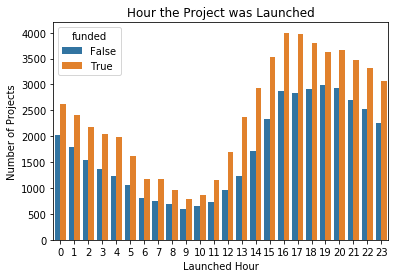

In [30]:
#extract launched hour and state for all states 'successful' and append the same for all states 'failed'.
#dff = df_train.loc[df_train['funded'] == True,['LaunchedHour', 'funded']]
#.append(df_train.loc[df_train['funded'] == False, ['LaunchedHour', 'funded']])

#plot the data
ax = sns.countplot(x=df_train['LaunchedHour'], 
              hue = df_train['funded'])
#set labels and title
ax.set(xlabel='Launched Hour', ylabel='Number of Projects', title= 'Hour the Project was Launched') 
plt.show()

### There are a few interesting things to observe in the above plot

1. In general, there are more projects launched either in the early morning (between 0 am and 5 am) and more projects launched in the late afternoon/evening (between 4 and 23 pm) compared to the time between 7 am and 3 pm.

2. The ratio between un-funded and funded projects varies over the time of the day. We can see that the ratio between failed and successful projects is almost 1 for projects launched between 9am and 11 am. In contrary, the ratio for projects launched after 3 pm is much less (in other words: by far more projects failed than succeeded).

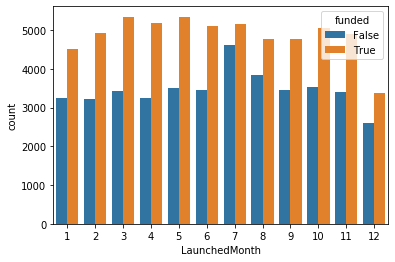

In [31]:
sns.countplot(x=df_train['LaunchedMonth'], 
              hue = df_train['funded'])
 
ax.set(xlabel='Month of the Year', 
       ylabel='Number of Projects', 
       title= 'Month the Project was Launched')
plt.show()

### Compared to the hour of the day, the months do not seem to reveal any surprising insights. However, note that there are by far fewer projects launched in December compared to all other months.

In [33]:
(df_test['DeadlineDate'] -df_test['LaunchedDate'])

0       23 days 00:00:00
1       19 days 04:57:41
2        5 days 00:00:00
3       60 days 00:00:00
4       18 days 00:26:54
              ...       
78060   29 days 09:35:34
78061   60 days 01:00:00
78062   29 days 12:11:37
78063   26 days 12:55:02
78064   27 days 06:59:40
Length: 78065, dtype: timedelta64[ns]

In [36]:
# 2019-11-09   -  2019-11-30

(df_test['DeadlineDate'] -df_test['LaunchedDate']).astype('timedelta64[D]')

0        23.0
1        19.0
2         5.0
3        60.0
4        18.0
         ... 
78060    29.0
78061    60.0
78062    29.0
78063    26.0
78064    27.0
Length: 78065, dtype: float64

In [37]:
(df_test['DeadlineDate'] -df_test['LaunchedDate']).astype('timedelta64[s]')

0        1987200.0
1        1659461.0
2         432000.0
3        5184000.0
4        1556814.0
           ...    
78060    2540134.0
78061    5187600.0
78062    2549497.0
78063    2292902.0
78064    2357980.0
Length: 78065, dtype: float64

#### We compute the project duration (in weeks)

In [41]:
# project duration in Days

df_test['ProjectDuration_Days'] =  (df_test['DeadlineDate'] -df_test['LaunchedDate']).astype('timedelta64[D]').astype('int') 
df_test['ProjectDuration_Days'].head(5)


df_train['ProjectDuration_Days'] =  (df_train['DeadlineDate'] -df_train['LaunchedDate']).astype('timedelta64[D]').astype('int') 
df_train['ProjectDuration_Days'].head(5)

0    21
1    40
2    60
3    21
4    30
Name: ProjectDuration_Days, dtype: int32

In [46]:
colors=('darkred','darkgreen')

In [42]:
# A method to bin the days to weeks
def discretizer(data, binning_values, labels): 
    data = pd.cut(data, bins=binning_values, labels=labels)
    return data

In [43]:
df_test['ProjectDuration_Weeks'] = discretizer(df_test['ProjectDuration_Days'],
  list(range(0,max(df_test['ProjectDuration_Days'])+7,7)),
 list(range(1,max(list(range(0,max(df_test['ProjectDuration_Days'])//7+2))))))

print(df_test['ProjectDuration_Weeks'].head(5)) 
    
    
    
df_train['ProjectDuration_Weeks'] = discretizer(df_train['ProjectDuration_Days'],
  list(range(0,max(df_train['ProjectDuration_Days'])+7,7)),
 list(range(1,max(list(range(0,max(df_train['ProjectDuration_Days'])//7+2))))))

df_train['ProjectDuration_Weeks'].head(5)



 
df_train[['ProjectDuration_Days', 'ProjectDuration_Weeks']].head(5)
 

0    4
1    3
2    1
3    9
4    3
Name: ProjectDuration_Weeks, dtype: category
Categories (13, int64): [1 < 2 < 3 < 4 ... 10 < 11 < 12 < 13]


,ProjectDuration_Days,ProjectDuration_Weeks
0,21,3
1,40,6
2,60,9
3,21,3
4,30,5


### No of projects vs  project duration  (for funded and non-funded project)

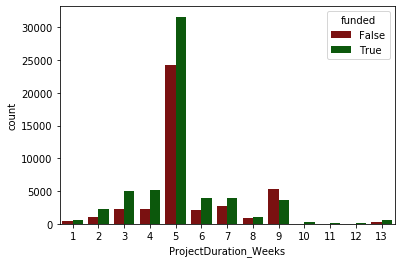

In [47]:
sns.countplot(x=df_train['ProjectDuration_Weeks'], 
              hue = df_train['funded'], palette=colors)
plt.show()

####  We observe that most projects are put on Kickstarter for about 5 weeks and almost all projects are live between 1 and 9 weeks (more than 2 months).

#### The proportion between funded  and non-funded projects varies over time: Projects with a short run time (1–7weeks) succeed relatively more often compared to projects that are launched with a medium to long run time (9  weeks). This insight could support the hypothesis that project are not more likely to funded when they are live long time so that  the more people have the chance to see it over time, the more likely it will succeed.  But from our current data it does not appear so.

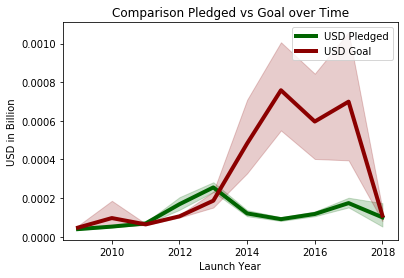

In [51]:
#let's use this variable to plot the data over time:
ax = sns.lineplot(x=df_train['LaunchedYear'], y= df_train['pledged']/1e8, linewidth= 4, label= 'USD Pledged', color= 'darkgreen')
sns.lineplot(x=df_train['LaunchedYear'], y=df_train['goal']/1e8, linewidth= 4,label='USD Goal', color= 'darkred')
#set labels and title
ax.set(xlabel='Launch Year', ylabel='USD in Billion', title='Comparison Pledged vs Goal over Time')
plt.show()

####   It can be seen that the accumulated pledged amount  sharply increases from 2013 and has its peak in 2015 before it slowly decreases. On the other hand, the accumulated goal amount for each year steadily decreases but rather linearly. It actually decreased slightly from 2013 to 2016.

       Time Difference  funded   pledged
0              8886055    True   3596.00
1              5514061    True   4586.00
2              5792845    True   5217.00
3              2463645    True   7160.00
4              7021623    True  15445.00
...                ...     ...       ...
99995          7874359    True   7595.43
99996          2734910    True  27196.71
99997          7659706    True   7226.00
99998          4477340    True  31683.00
99999          2868430    True   7555.00

[100000 rows x 3 columns]


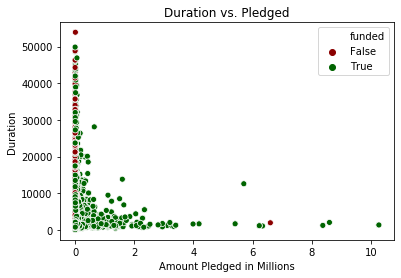

In [52]:
data = {'Time Difference':  df_train['deadline']-df_train['created_at'], 
        'funded':df_train['funded'],
        'pledged': df_train['pledged']} 
df_new = pd.DataFrame(data, columns = ['Time Difference', 'funded','pledged']) 
print(df_new)  

colors=('darkred','darkgreen',)
ax = sns.scatterplot(x=df_new['pledged']/1e6, 
                     y=df_new['Time Difference']/3600, 
                     hue=df_new['funded'], palette=colors)

ax.set(xlabel='Amount Pledged in Millions', ylabel='Duration', title= 'Duration vs. Pledged')

plt.show()


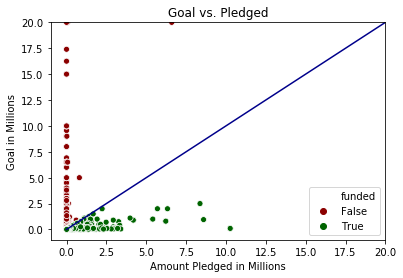

In [53]:
colors=('darkred','darkgreen')
ax = sns.scatterplot(x=df_train['pledged']/1e6, 
                     y=df_train['goal']/1e6, 
                     hue=df_train['funded'], palette=colors)
#add blue line to better visualize the border between failed and successful projects
sns.lineplot(x=(0,50), y=(0,50), color='darkblue')
ax.set(ylim=(-1,20), xlim=(-1,20))
#set labels and title
ax.set(xlabel='Amount Pledged in Millions', ylabel='Goal in Millions', title= 'Goal vs. Pledged')
plt.show()


#### Interestingly, the graph suggests that un-funded projects usually fail without coming even  close to their goal, meaning that they “do not move horizontally towards the blue line but stay at x=0”.  This leads to the conclusion that Kickstarter if we don’t make it,  we probably didn’t even come close. On the other hand, many funded projects exceed their stated goal  by far and pledge a multiple of their initial goal. 

## Role of backers 

It is expected that the number of backers contribute positively to the success for a specific project. But is this really true with the data at hand? In order to explore this, we visualize the number of backers, amount pledged and the state of the project.

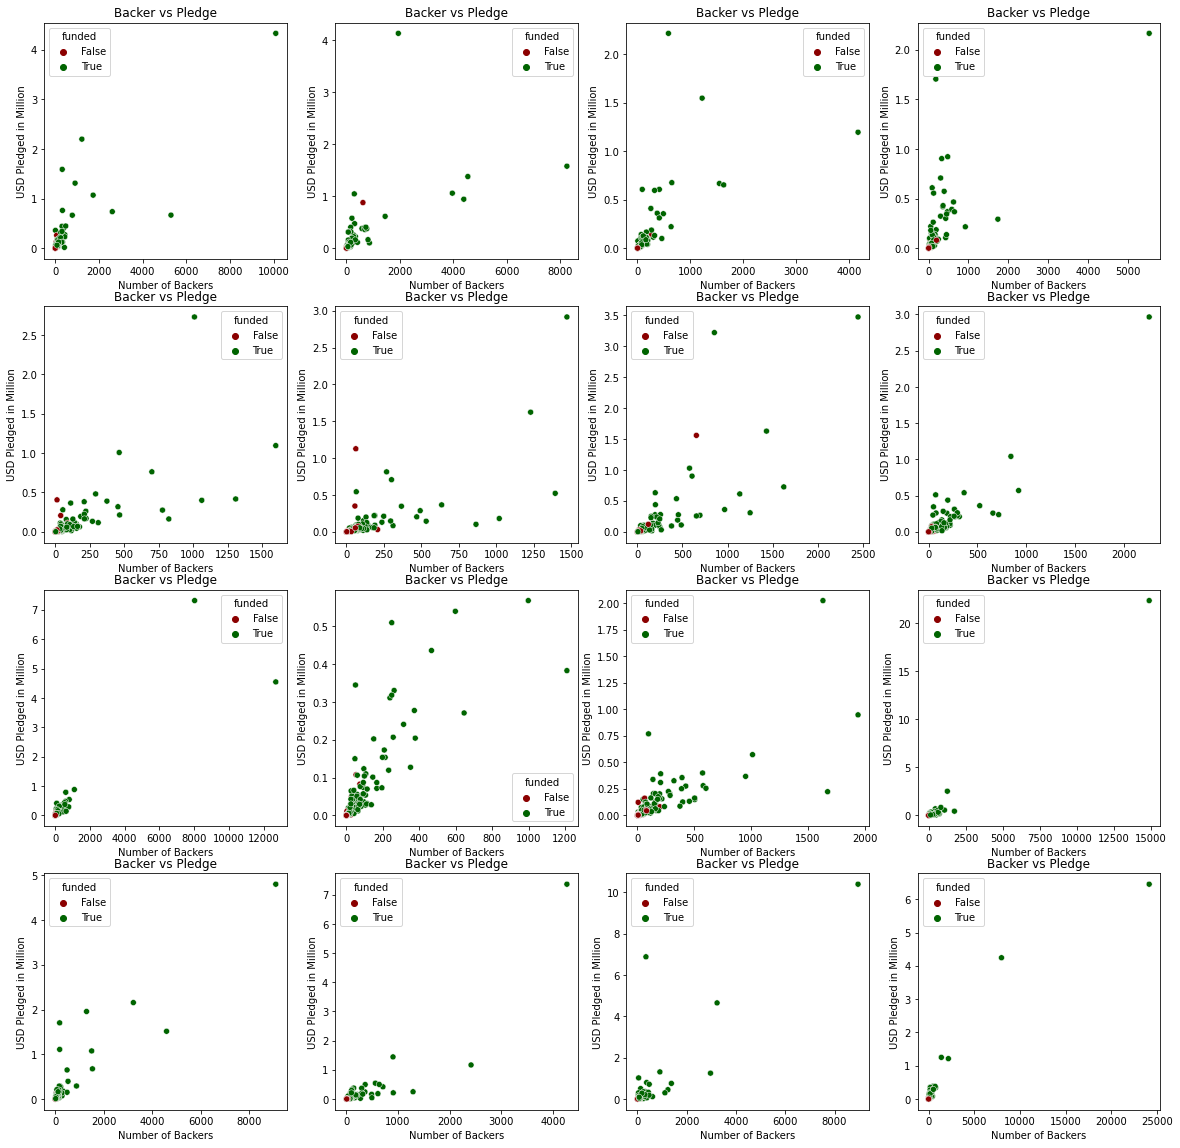

In [294]:
colors = ('darkred','darkgreen')
new=['backers_count','pledged','funded']


NoS=200

fig, axes =plt.subplots(4,4,figsize=(20, 20))

for row in  range(4):
    for col in  range(4): 
        df_new=df_train.iloc[random.sample(range(100000),NoS),df_train.columns.isin(new)] 
        sns.scatterplot(ax=axes[row,col],
                    x=df_new['backers_count'], 
                     y=df_new['pledged']/1e5, 
                     hue=df_new['funded'], 
                     palette=colors) 
     
        axes[row,col].set(xlabel='Number of Backers', 
               ylabel='USD Pledged in Million', 
               title= 'Backer vs Pledge')
    

#### From this result, we  can clearly see that the number of backers correlates with the funding status of a project.  Most projects that are not-funded also have a (relatively) smaller number of backers.  

In [295]:
print(np.max(df_train['backers_count'].unique()))
print(np.min(df_train['backers_count'].unique()))

print(np.max(df_train['pledged']))
print(np.min(df_train['pledged']))

105857
0
10266845.74
0.0


In [297]:
# Exploring the relationshipe between project category-wise funding status 
Category_funded = pd.crosstab(index=df_train['funded'], 
                           columns=df_train['subcategory'],
                             margins=True)

a=list(df_train['subcategory'].unique())
a.append('Col. Total')
Category_funded.columns= a 
Category_funded.index= ['Funded','Not-funded','rowtotal']
Category_funded

,mixed media,public art,sculpture,art,painting,conceptual art,digital art,performance art,illustration,ceramics,...,sound,flight,camera equipment,space exploration,fabrication tools,theater,musical,plays,immersive,Col. Total
Funded,199,340,666,290,102,860,119,464,1067,262,...,34,1907,146,359,454,53,600,305,101,41546
Not-funded,163,88,632,66,57,416,297,819,242,102,...,27,395,214,1015,337,64,575,97,113,58454
rowtotal,362,428,1298,356,159,1276,416,1283,1309,364,...,61,2302,360,1374,791,117,1175,402,214,100000


In [298]:
# Exploring project category-wise funding status 
Category_funded = pd.crosstab(index=df_train['subcategory'],
                              columns=df_train['funded'],  
                             margins=True)

a=list(df_train['subcategory'].unique())
a.append('Row. Total')
Category_funded.index= a 
Category_funded.columns= ['Funded','Not-funded','Col.total']
Category_funded

,Funded,Not-funded,Col.total
mixed media,199,163,362
public art,340,88,428
sculpture,666,632,1298
art,290,66,356
painting,102,57,159
...,...,...,...
theater,53,64,117
musical,600,575,1175
plays,305,97,402
immersive,101,113,214


In [55]:
nam="JunHeong"

len(nam)

8

In [60]:
# To find the effect of name length on project funding if any 

df_test['ProNameLength'] = df_test['name'].str.len()
df_train['ProNameLength'] = df_train['name'].str.len()
#df_train['ProNameLength'].describe()

print(df_train.loc[:,['name','ProNameLength']].head(10))
 

                                                name  ProNameLength
0     Elsewhere Studios artist-in-residency program!           46.0
1       1000 Artists: Presidential Inauguration 2013           44.0
2                                       MyPhoneHenge           12.0
3                                       Walk-Through           12.0
4                     A kitchen for Habitable Spaces           30.0
5  Source Material: Works by Brian Dupont and Chr...           54.0
6                                  A Book of Dwarves           17.0
7                              Drawing a Drawing 365           21.0
8  The Vermont Studio Center Artist Residency Pro...           50.0
9                             Arts on the Waterfront           22.0


In [61]:
df_train.dtypes

project_id                          object
backers_count                        int64
blurb                               object
category                            object
converted_pledged_amount             int64
country                             object
created_at                           int64
currency                            object
deadline                             int64
fx_rate                            float64
goal                               float64
launched_at                          int64
name                                object
pledged                            float64
staff_pick                            bool
usd_pledged                        float64
location                            object
funded                                bool
subcategory                         object
project_url                         object
reward_url                          object
LaunchedDate                datetime64[ns]
DeadlineDate                datetime64[ns]
LaunchedHou

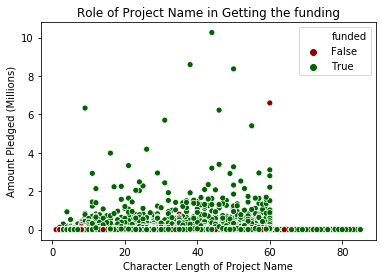

In [62]:
ax = sns.scatterplot(y=df_train['pledged']/1e6, 
                     x=df_train['ProNameLength'], 
                     hue=df_train['funded'],
                     palette=colors)
#set labels accordingly
ax.set(ylabel='Amount Pledged (Millions)', 
       xlabel='Character Length of Project Name', 
       title= 'Role of Project Name in Getting the funding')

plt.show()

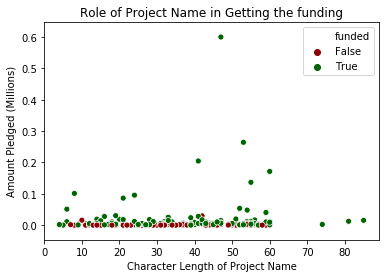

In [67]:
df_random=df_train.sample(200)


ax = sns.scatterplot(y=df_random['pledged']/1e6, 
                     x=df_random['ProNameLength'], 
                     hue=df_random['funded'],
                     palette=colors)
#set labels accordingly
ax.set(ylabel='Amount Pledged (Millions)', 
       xlabel='Character Length of Project Name', 
       title= 'Role of Project Name in Getting the funding')

plt.show()

In [68]:
from collections import Counter
Counter(df_train['funded'])

Counter({True: 58454, False: 41546})

### Looks like projects with titles character length more than 60 has a greater propbability to get the funding so we think project name character length could be an additional feature

In [301]:
# Looking at how many poject with length greater than 60 funded (True) or not-funded (False)
plength=60

df_new=df_train.iloc[df_train[df_train['ProNameLength']>plength].index,df_train.columns.isin(new)]
dict(df_new['funded'].value_counts())

{True: 706, False: 158}

In [302]:
# Relationship among the numerical variables in the data

print(df_train.columns)

print(df_test.columns)

Index(['project_id', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'pledged',
       'staff_pick', 'usd_pledged', 'location', 'funded', 'subcategory',
       'project_url', 'reward_url', 'LaunchedDate', 'DeadlineDate',
       'LaunchedHour', 'LaunchedMonth', 'LaunchedYear', 'ProjectDuration_Days',
       'ProjectDuration_Weeks', 'ProNameLength'],
      dtype='object')
Index(['project_id', 'blurb', 'category', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'staff_pick',
       'location', 'subcategory', 'project_url', 'reward_url', 'LaunchedDate',
       'DeadlineDate', 'LaunchedHour', 'LaunchedMonth', 'LaunchedYear',
       'ProjectDuration_Days', 'ProjectDuration_Weeks', 'ProNameLength'],
      dtype='object')


# Relationship (Pearson correlation) between numerical features

In [303]:
features=['backers_count','converted_pledged_amount','goal','LaunchedHour','ProNameLength','fx_rate']
#features=['backers_count','converted_pledged_amount','goal','LaunchedHour','ProjectDuration_Weeks']
df_train['ProjectDuration_Weeks']=df_train['ProjectDuration_Weeks'].astype(int)
features=['backers_count','converted_pledged_amount','goal','LaunchedHour','ProNameLength','ProjectDuration_Weeks']

dff= df_train[features]
dff.corr().round(3)
 


,backers_count,converted_pledged_amount,goal,LaunchedHour,ProNameLength,ProjectDuration_Weeks
backers_count,1.000,0.815,0.009,-0.005,0.019,0.003
converted_pledged_amount,0.815,1.000,0.009,-0.006,0.034,0.010
goal,0.009,0.009,1.000,0.002,-0.005,0.022
LaunchedHour,-0.005,-0.006,0.002,1.000,-0.006,-0.026
ProNameLength,0.019,0.034,-0.005,-0.006,1.000,0.015
ProjectDuration_Weeks,0.003,0.010,0.022,-0.026,0.015,1.000


####  The above correlation among the features suggest that most of the variables are uncorrelated with each other which is good for prediction analysis.

In [304]:
df_train['ProjectDuration_Weeks'].astype(int)

0        3
1        6
2        9
3        3
4        5
        ..
99995    5
99996    5
99997    6
99998    5
99999    4
Name: ProjectDuration_Weeks, Length: 100000, dtype: int64

# 4. Prediction Analysis (kNN estimator):

## 4a. kNN-based Prediction Analysis:

In [69]:
# WE have not included 'backers_count','converted_pledged_amount'

features=['goal','LaunchedHour','ProNameLength','ProjectDuration_Weeks','staff_pick','funded']
        


print(df_train[features].isnull().sum())

# Removing observation with NaN values

df=df_train[features].dropna()

print(df.isnull().sum())

df.head()
df.shape

goal                     0
LaunchedHour             0
ProNameLength            1
ProjectDuration_Weeks    0
staff_pick               0
funded                   0
dtype: int64
goal                     0
LaunchedHour             0
ProNameLength            0
ProjectDuration_Weeks    0
staff_pick               0
funded                   0
dtype: int64


(99999, 6)

## 4b.Choosing the value of K using 5-fold cross-validation:

In [70]:
# Form the Training and Validation data from the Training set

# Original Training set
Y=df['funded']
X=df.drop(['funded'],axis=1) 


# Train (85%) and Validation data (15%) split

X_train, X_valid, Y_train, Y_valid=train_test_split(X, Y, test_size=0.15)

# CROSS VALDATION with cross-validation factor 5
# Obtaining value of K using Validation data set with Cross-validation factor of 5


 
knn = KNeighborsClassifier()  #Knn model

param_grid = {"n_neighbors": np.arange(1, 25)} #create a dictionary of all values we want to test for n_neighbors

knn_gscv = GridSearchCV(knn, param_grid, cv=5) #use gridsearch to test all values for n_neighbors

knn_gscv.fit(X_valid, Y_valid)        #fit Knn-model to validataion data sets

print(knn_gscv.best_params_ )          #Best K value

print("The optimal value of K using the validation data is ",knn_gscv.best_params_['n_neighbors'])

 


{'n_neighbors': 19}
The optimal value of K using the validation data is  19


 # Using optimal K in the training data set



In [71]:
# Using optimal value in the training set

knn_train = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'] )
knn_train.fit(X_train, Y_train)

print("The average accuracy (in percentage) using optimal value of K in the training data set is {}".format(knn_train.score(X_train,Y_train)*100))


The average accuracy (in percentage) using optimal value of K in the training data set is 68.04668290215179


 # Using optimal K in the test data set



In [309]:
# Using optimal value in the test set
features=['goal','LaunchedHour','ProNameLength','ProjectDuration_Weeks','staff_pick']
 
    
df_test.columns    
 
Predicted_funded_knn=knn_train.predict(df_test[features])
 
print(Predicted_funded_knn)

[False  True  True ... False False  True]


# 4. Prediction Analysis:  (Decision tree estimator):

In [72]:
# CART
tree_model = DecisionTreeClassifier()  # Decision tree

param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

tree_gscv = GridSearchCV(tree_model, param_grid, cv=5) #use gridsearch to test all values for the parameters

tree_gscv.fit(X_valid, Y_valid)        #fit tree model to validation data

print(tree_gscv.best_params_ )          #check top performing n_neighbors value

 


 

{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


 # Using optimal parameters in the training data set



In [73]:
 
fit=tree_gscv.fit(X_train, Y_train)

print("The average accuracy (in percentage) using optimal parameter value of in the training data set is {}".format(fit.score(X_train, Y_train)*100))


The average accuracy (in percentage) using optimal parameter value of in the training data set is 69.27493264626644


 # Using optimal parameters in the test data set



In [312]:
# Using optimal value in the test set
features=['goal','LaunchedHour','ProNameLength','ProjectDuration_Weeks','staff_pick']
 
    
df_test.columns    
 
Predicted_funded_tree=fit.predict(df_test[features])
 
print(Predicted_funded_tree)

[ True  True False ...  True False  True]


# 5. Performance analysis of Prediction

In [313]:
## For the Knn
print("KNN: The average accuracy (in percentage) using optimal value of K in the training data set is {}".format(knn_train.score(X_train,Y_train)*100))


## For the Decision-tree classifer

print("TREE: The average accuracy (in percentage) using optimal paramter value in the training data set is {}".format(fit.score(X_train, Y_train)*100))


KNN: The average accuracy (in percentage) using optimal value of K in the training data set is 67.41138131036836
TREE: The average accuracy (in percentage) using optimal paramter value in the training data set is 69.40787538676926


# 6. Feature Selection

###  Here we use only the training data sets because we found that the features  'backers_count','converted_pledged_amount' improves the prediction accuracy by nearly 30% if inlcuded for analysis. Since these features are not available for the test data, we use only the training set.


In [314]:
features=['backers_count','converted_pledged_amount','goal','LaunchedHour','ProNameLength','ProjectDuration_Weeks','staff_pick','funded']
 
# Removing observation with NaN values

df=df_train[features].dropna()

 
# Original Training set
Y=df['funded']
X=df.drop(['funded'],axis=1) 


# Train (85%) and Validation data (15%) split

X_train, X_valid, Y_train, Y_valid=train_test_split(X, Y, test_size=0.15)

# CROSS VALDATION with cross-validation factor 5
# Obtaining value of K using Validation data set with Cross-validation factor of 5


 
knn = KNeighborsClassifier()  #Knn model

param_grid = {"n_neighbors": np.arange(1, 25)} #create a dictionary of all values we want to test for n_neighbors

knn_gscv = GridSearchCV(knn, param_grid, cv=5) #use gridsearch to test all values for n_neighbors

knn_gscv.fit(X_valid, Y_valid)        #fit Knn-model to validataion data sets

print(knn_gscv.best_params_ )          #Best K value

print("The optimal value of K using the validation data is ",knn_gscv.best_params_['n_neighbors'])


knn_train = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'] )
knn_train.fit(X_train, Y_train)

print("The average accuracy (in percentage) using optimal value of K in the training data set is {}".format(knn_train.score(X_train,Y_train)*100))






{'n_neighbors': 4}
The optimal value of K using the validation data is  4
The average accuracy (in percentage) using optimal value of K in the training data set is 99.09881292721091


In [315]:
 
tree_model = DecisionTreeClassifier()  # Decision tree

param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

tree_gscv = GridSearchCV(tree_model, param_grid, cv=5) #use gridsearch to test all values for the parameters

tree_gscv.fit(X_valid, Y_valid)        #fit tree model to validation data

print(tree_gscv.best_params_ )          #check top performing n_neighbors value

   
    
fit=tree_gscv.fit(X_train, Y_train)



{'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [316]:
## For the Knn
print("KNN: The average accuracy (in percentage) using optimal value of K in the training data set is {}".format(knn_train.score(X_train,Y_train)*100))


## For the Decision-tree classifer

print("TREE: The average accuracy (in percentage) using optimal paramter value in the training data set is {}".format(fit.score(X_train, Y_train)*100))


KNN: The average accuracy (in percentage) using optimal value of K in the training data set is 99.09881292721091
TREE: The average accuracy (in percentage) using optimal paramter value in the training data set is 98.98939987529265


###  We note that with the training set and the new additional features that is 'backers_count','converted_pledged_amount'  the prediction accuracy improves!


In [74]:
## K-means clustering
from sklearn.cluster import KMeans

In [75]:
 model=KMeans(2)  # Funded  and non-funded
 model.fit(X)  # only two features

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [76]:
model.cluster_centers_

array([[2.80016458e+04, 1.35199192e+01, 3.49754448e+01, 5.35329419e+00,
        1.39529301e-01],
       [8.23950000e+07, 1.44000000e+01, 3.47000000e+01, 6.65000000e+00,
        2.77555756e-17]])

In [ ]:
features=['goal','LaunchedHour','ProNameLength','ProjectDuration_Weeks','staff_pick']
 

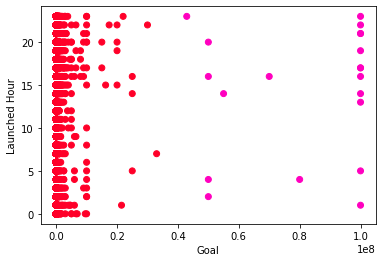

In [79]:
plt.scatter(X.iloc[:,0],X.iloc[:,1],c=model.labels_,cmap='gist_rainbow')   # hue is sns
plt.xlabel("Goal")
plt.ylabel("Launched Hour")
plt.show()

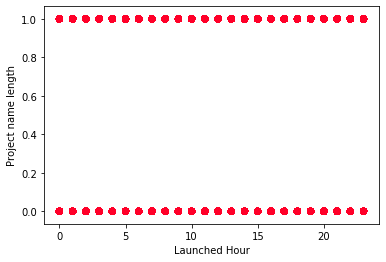

In [82]:
plt.scatter(X.iloc[:,1],X.iloc[:,4],c=model.labels_,cmap='gist_rainbow')   # hue is sns
plt.ylabel("Project name length")
plt.xlabel("Launched Hour")
plt.show() 